# Research Question 7: Regional Discrepancies Analysis

**Question**: Which countries exhibited the largest gaps between peak mobility reductions and peak negative sentiment?

**Datasets**: Google Mobility (Dataset 2), JHU CSSE Cases (Dataset 4) & COVID-19 Tweets (Dataset 1)

**Approach**: 
1. Identify peak mobility reductions by country during the analysis period
2. Calculate peak negative sentiment periods by region/country
3. Measure temporal and magnitude gaps between these peaks
4. Rank countries by discrepancy size and analyze patterns

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style for professional visualizations
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("Libraries loaded successfully!")
print("Analysis: Regional Discrepancies - Mobility vs Sentiment")

Libraries loaded successfully!
Analysis: Regional Discrepancies - Mobility vs Sentiment


## Data Loading and Preparation

In [40]:
# Load datasets
try:
    # Load processed tweet data
    tweets_df = pd.read_csv('../data/processed/tweets_with_nlp_features.csv')
    daily_tweets = pd.read_csv('../data/processed/daily_tweet_sentiment_topics.csv')
    
    # Load Google Mobility data
    mobility_df = pd.read_csv('../data/raw/google_mobility/Global_Mobility_Report.csv')
    
    # Load JHU cases for context
    cases_df = pd.read_csv('../data/raw/jhu_csse/time_series_covid19_confirmed_global.csv')
    
    print(f"Tweet data loaded: {tweets_df.shape}")
    print(f"Daily aggregated tweets: {daily_tweets.shape}")
    print(f"Mobility data: {mobility_df.shape}")
    print(f"Cases data: {cases_df.shape}")
    
    # Convert date columns
    tweets_df['date'] = pd.to_datetime(tweets_df['date'])
    daily_tweets['date_only'] = pd.to_datetime(daily_tweets['date_only'])
    mobility_df['date'] = pd.to_datetime(mobility_df['date'])
    
    print("\nData loaded and dates converted successfully!")
    
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure all required data files exist.")

Tweet data loaded: (162827, 28)
Daily aggregated tweets: (26, 12)
Mobility data: (11730025, 15)
Cases data: (289, 1147)

Data loaded and dates converted successfully!

Data loaded and dates converted successfully!


In [41]:
# Process mobility data for major countries during tweet period
print("Processing mobility data...")

# Focus on tweet period
tweet_start = pd.to_datetime('2020-07-24')
tweet_end = pd.to_datetime('2020-08-19')

# Filter mobility data for country-level (no sub-regions) and tweet period
mobility_filtered = mobility_df[
    (mobility_df['sub_region_1'].isna()) &  # Country level only
    (mobility_df['date'] >= tweet_start) & 
    (mobility_df['date'] <= tweet_end)
].copy()

# Define major countries with significant data
major_countries = [
    'United States', 'United Kingdom', 'Germany', 'France', 'Italy', 'Spain', 
    'Canada', 'Australia', 'Brazil', 'India', 'Japan', 'South Korea'
]

mobility_major = mobility_filtered[mobility_filtered['country_region'].isin(major_countries)].copy()

# Calculate composite mobility reduction (average of key categories)
mobility_categories = [
    'retail_and_recreation_percent_change_from_baseline',
    'workplaces_percent_change_from_baseline',
    'transit_stations_percent_change_from_baseline'
]

# Fill missing values with 0 and calculate composite mobility
for col in mobility_categories:
    mobility_major[col] = mobility_major[col].fillna(0)

mobility_major['composite_mobility_change'] = mobility_major[mobility_categories].mean(axis=1)
mobility_major['mobility_reduction'] = -mobility_major['composite_mobility_change']  # Convert to reduction scale

print(f"Mobility data processed for {len(mobility_major['country_region'].unique())} countries")
print(f"Date range: {mobility_major['date'].min()} to {mobility_major['date'].max()}")
print(f"Countries: {sorted(mobility_major['country_region'].unique())}")

Processing mobility data...
Mobility data processed for 12 countries
Date range: 2020-07-24 00:00:00 to 2020-08-19 00:00:00
Countries: ['Australia', 'Brazil', 'Canada', 'France', 'Germany', 'India', 'Italy', 'Japan', 'South Korea', 'Spain', 'United Kingdom', 'United States']
Mobility data processed for 12 countries
Date range: 2020-07-24 00:00:00 to 2020-08-19 00:00:00
Countries: ['Australia', 'Brazil', 'Canada', 'France', 'Germany', 'India', 'Italy', 'Japan', 'South Korea', 'Spain', 'United Kingdom', 'United States']


In [42]:
# Process sentiment data - need to map tweets to countries based on user_location
print("Processing sentiment data and mapping to countries...")

# Create country mapping based on user_location (simplified mapping)
def map_location_to_country(location):
    if pd.isna(location) or location == '':
        return 'Unknown'
    
    location = str(location).lower()
    
    # Simple keyword mapping
    country_mappings = {
        'united states': ['usa', 'america', 'us', 'united states', 'new york', 'california', 'texas', 'florida'],
        'United Kingdom': ['uk', 'united kingdom', 'england', 'london', 'britain', 'scotland', 'wales'],
        'Canada': ['canada', 'toronto', 'vancouver', 'montreal'],
        'Australia': ['australia', 'sydney', 'melbourne', 'aussie'],
        'Germany': ['germany', 'deutschland', 'berlin', 'munich'],
        'France': ['france', 'paris', 'french'],
        'Italy': ['italy', 'italia', 'rome', 'milan'],
        'Spain': ['spain', 'madrid', 'barcelona', 'españa'],
        'India': ['india', 'mumbai', 'delhi', 'bangalore', 'chennai'],
        'Brazil': ['brazil', 'brasil', 'são paulo', 'rio'],
        'Japan': ['japan', 'tokyo', 'japanese'],
        'South Korea': ['korea', 'seoul']
    }
    
    for country, keywords in country_mappings.items():
        if any(keyword in location for keyword in keywords):
            return country
    
    return 'Other'

# Map tweets to countries
tweets_df['mapped_country'] = tweets_df['user_location'].apply(map_location_to_country)

# Filter tweets for major countries
tweets_major_countries = tweets_df[tweets_df['mapped_country'].isin(major_countries)].copy()

# Calculate daily sentiment by country
daily_sentiment_by_country = tweets_major_countries.groupby(
    ['mapped_country', tweets_major_countries['date'].dt.date]
).agg({
    'vader_compound': ['mean', 'count'],
    'sentiment_label': lambda x: (x == 'negative').mean() * 100  # Percentage negative
}).round(4)

daily_sentiment_by_country.columns = ['avg_sentiment', 'tweet_count', 'negative_sentiment_pct']
daily_sentiment_by_country = daily_sentiment_by_country.reset_index()
daily_sentiment_by_country.columns = ['country', 'date', 'avg_sentiment', 'tweet_count', 'negative_sentiment_pct']
daily_sentiment_by_country['date'] = pd.to_datetime(daily_sentiment_by_country['date'])

# Filter for countries with sufficient data
country_tweet_counts = tweets_major_countries['mapped_country'].value_counts()
sufficient_data_countries = country_tweet_counts[country_tweet_counts >= 100].index.tolist()

print(f"\nCountries with sufficient tweet data (≥100 tweets):")
for country in sufficient_data_countries:
    count = country_tweet_counts[country]
    print(f"  {country}: {count:,} tweets")

daily_sentiment_filtered = daily_sentiment_by_country[
    daily_sentiment_by_country['country'].isin(sufficient_data_countries)
]

print(f"\nDaily sentiment data prepared for {len(sufficient_data_countries)} countries")

Processing sentiment data and mapping to countries...

Countries with sufficient tweet data (≥100 tweets):
  India: 16,438 tweets
  United Kingdom: 12,025 tweets
  Canada: 3,855 tweets
  Australia: 933 tweets
  Brazil: 706 tweets
  Germany: 686 tweets
  France: 525 tweets
  Spain: 353 tweets
  Japan: 348 tweets
  Italy: 295 tweets
  South Korea: 107 tweets

Daily sentiment data prepared for 11 countries

Countries with sufficient tweet data (≥100 tweets):
  India: 16,438 tweets
  United Kingdom: 12,025 tweets
  Canada: 3,855 tweets
  Australia: 933 tweets
  Brazil: 706 tweets
  Germany: 686 tweets
  France: 525 tweets
  Spain: 353 tweets
  Japan: 348 tweets
  Italy: 295 tweets
  South Korea: 107 tweets

Daily sentiment data prepared for 11 countries


## Peak Analysis - Mobility vs Sentiment

In [43]:
# Find peaks for each country
print("Identifying peaks in mobility reduction and negative sentiment...")

peak_analysis_results = []

# Analyze countries that have both mobility and sentiment data
common_countries = set(mobility_major['country_region'].unique()) & set(sufficient_data_countries)
print(f"\nAnalyzing {len(common_countries)} countries with both datasets:")
print(sorted(common_countries))

for country in sorted(common_countries):
    print(f"\n--- Analyzing {country} ---")
    
    # Get mobility data for country
    country_mobility = mobility_major[mobility_major['country_region'] == country].copy()
    country_mobility = country_mobility.sort_values('date')
    
    # Get sentiment data for country
    country_sentiment = daily_sentiment_filtered[daily_sentiment_filtered['country'] == country].copy()
    country_sentiment = country_sentiment.sort_values('date')
    
    if len(country_mobility) < 5 or len(country_sentiment) < 5:
        print(f"  Insufficient data for {country}")
        continue
    
    # Find peak mobility reduction (maximum reduction)
    peak_mobility_idx = country_mobility['mobility_reduction'].idxmax()
    peak_mobility_date = country_mobility.loc[peak_mobility_idx, 'date']
    peak_mobility_value = country_mobility.loc[peak_mobility_idx, 'mobility_reduction']
    
    # Find peak negative sentiment (maximum negative sentiment percentage)
    peak_sentiment_idx = country_sentiment['negative_sentiment_pct'].idxmax()
    peak_sentiment_date = country_sentiment.loc[peak_sentiment_idx, 'date']
    peak_sentiment_value = country_sentiment.loc[peak_sentiment_idx, 'negative_sentiment_pct']
    
    # Calculate time gap (sentiment peak - mobility peak)
    time_gap_days = (peak_sentiment_date - peak_mobility_date).days
    
    # Calculate normalized magnitude gap
    # Normalize both metrics to 0-1 scale for comparison
    mobility_normalized = (peak_mobility_value - country_mobility['mobility_reduction'].min()) / \
                         (country_mobility['mobility_reduction'].max() - country_mobility['mobility_reduction'].min())
    
    sentiment_normalized = (peak_sentiment_value - country_sentiment['negative_sentiment_pct'].min()) / \
                          (country_sentiment['negative_sentiment_pct'].max() - country_sentiment['negative_sentiment_pct'].min())
    
    magnitude_gap = abs(sentiment_normalized - mobility_normalized)
    
    # Store results
    peak_analysis_results.append({
        'country': country,
        'peak_mobility_date': peak_mobility_date,
        'peak_mobility_reduction': peak_mobility_value,
        'peak_sentiment_date': peak_sentiment_date,
        'peak_negative_sentiment': peak_sentiment_value,
        'time_gap_days': time_gap_days,
        'magnitude_gap': magnitude_gap,
        'mobility_data_points': len(country_mobility),
        'sentiment_data_points': len(country_sentiment)
    })
    
    print(f"  Peak mobility reduction: {peak_mobility_value:.1f}% on {peak_mobility_date.strftime('%Y-%m-%d')}")
    print(f"  Peak negative sentiment: {peak_sentiment_value:.1f}% on {peak_sentiment_date.strftime('%Y-%m-%d')}")
    print(f"  Time gap: {time_gap_days} days")
    print(f"  Magnitude gap (normalized): {magnitude_gap:.3f}")

# Convert to DataFrame
peak_results_df = pd.DataFrame(peak_analysis_results)
peak_results_df = peak_results_df.sort_values('magnitude_gap', ascending=False)

print(f"\nCompleted peak analysis for {len(peak_results_df)} countries")

Identifying peaks in mobility reduction and negative sentiment...

Analyzing 11 countries with both datasets:
['Australia', 'Brazil', 'Canada', 'France', 'Germany', 'India', 'Italy', 'Japan', 'South Korea', 'Spain', 'United Kingdom']

--- Analyzing Australia ---
  Peak mobility reduction: 32.3% on 2020-08-09
  Peak negative sentiment: 100.0% on 2020-07-30
  Time gap: -10 days
  Magnitude gap (normalized): 0.000

--- Analyzing Brazil ---
  Peak mobility reduction: 29.3% on 2020-07-29
  Peak negative sentiment: 61.1% on 2020-08-09
  Time gap: 11 days
  Magnitude gap (normalized): 0.000

--- Analyzing Canada ---
  Peak mobility reduction: 45.7% on 2020-08-03
  Peak negative sentiment: 37.9% on 2020-08-30
  Time gap: 27 days
  Magnitude gap (normalized): 0.000

--- Analyzing France ---
  Peak mobility reduction: 28.0% on 2020-08-12
  Peak negative sentiment: 55.6% on 2020-08-10
  Time gap: -2 days
  Magnitude gap (normalized): 0.000

--- Analyzing Germany ---
  Peak mobility reduction: 22.

In [44]:
# Rank countries by discrepancy and analyze patterns
print("REGIONAL DISCREPANCIES RANKING")
print("=" * 70)
print(f"{'Rank':<4} {'Country':<15} {'Time Gap':<10} {'Mag Gap':<10} {'Discrepancy':<12}")
print("-" * 70)

# Calculate composite discrepancy score
peak_results_df['abs_time_gap'] = abs(peak_results_df['time_gap_days'])
peak_results_df['composite_discrepancy'] = (
    (peak_results_df['abs_time_gap'] / peak_results_df['abs_time_gap'].max()) * 0.6 +
    (peak_results_df['magnitude_gap'] / peak_results_df['magnitude_gap'].max()) * 0.4
)

peak_results_df = peak_results_df.sort_values('composite_discrepancy', ascending=False)

for idx, (_, row) in enumerate(peak_results_df.iterrows(), 1):
    print(f"{idx:<4} {row['country']:<15} {row['time_gap_days']:>7} days {row['magnitude_gap']:>8.3f} {row['composite_discrepancy']:>10.3f}")

print("\nTOP 3 COUNTRIES WITH LARGEST DISCREPANCIES:")
print("=" * 50)

for idx, (_, row) in enumerate(peak_results_df.head(3).iterrows(), 1):
    print(f"\n{idx}. {row['country']}:")
    print(f"   Peak mobility reduction: {row['peak_mobility_reduction']:.1f}% on {row['peak_mobility_date'].strftime('%Y-%m-%d')}")
    print(f"   Peak negative sentiment: {row['peak_negative_sentiment']:.1f}% on {row['peak_sentiment_date'].strftime('%Y-%m-%d')}")
    print(f"   Time gap: {row['time_gap_days']} days ({'sentiment leads' if row['time_gap_days'] < 0 else 'mobility leads'})")
    print(f"   Magnitude discrepancy: {row['magnitude_gap']:.3f}")
    print(f"   Composite discrepancy score: {row['composite_discrepancy']:.3f}")

REGIONAL DISCREPANCIES RANKING
Rank Country         Time Gap   Mag Gap    Discrepancy 
----------------------------------------------------------------------
1    Australia           -10 days    0.000        nan
2    Brazil               11 days    0.000        nan
3    Canada               27 days    0.000        nan
4    France               -2 days    0.000        nan
5    Germany              -5 days    0.000        nan
6    India                -1 days    0.000        nan
7    Italy                -7 days    0.000        nan
8    Japan                 5 days    0.000        nan
9    South Korea         -16 days    0.000        nan
10   Spain                15 days    0.000        nan
11   United Kingdom       -3 days    0.000        nan

TOP 3 COUNTRIES WITH LARGEST DISCREPANCIES:

1. Australia:
   Peak mobility reduction: 32.3% on 2020-08-09
   Peak negative sentiment: 100.0% on 2020-07-30
   Time gap: -10 days (sentiment leads)
   Magnitude discrepancy: 0.000
   Composite discre

## Visualizations

Creating scatter plot visualization...
Data check - peak_results_df shape: (11, 11)
Time gap range: -16 to 27
Magnitude gap range: 0.000 to 0.000
No valid data after cleaning NaN values
No valid ranking data after cleaning


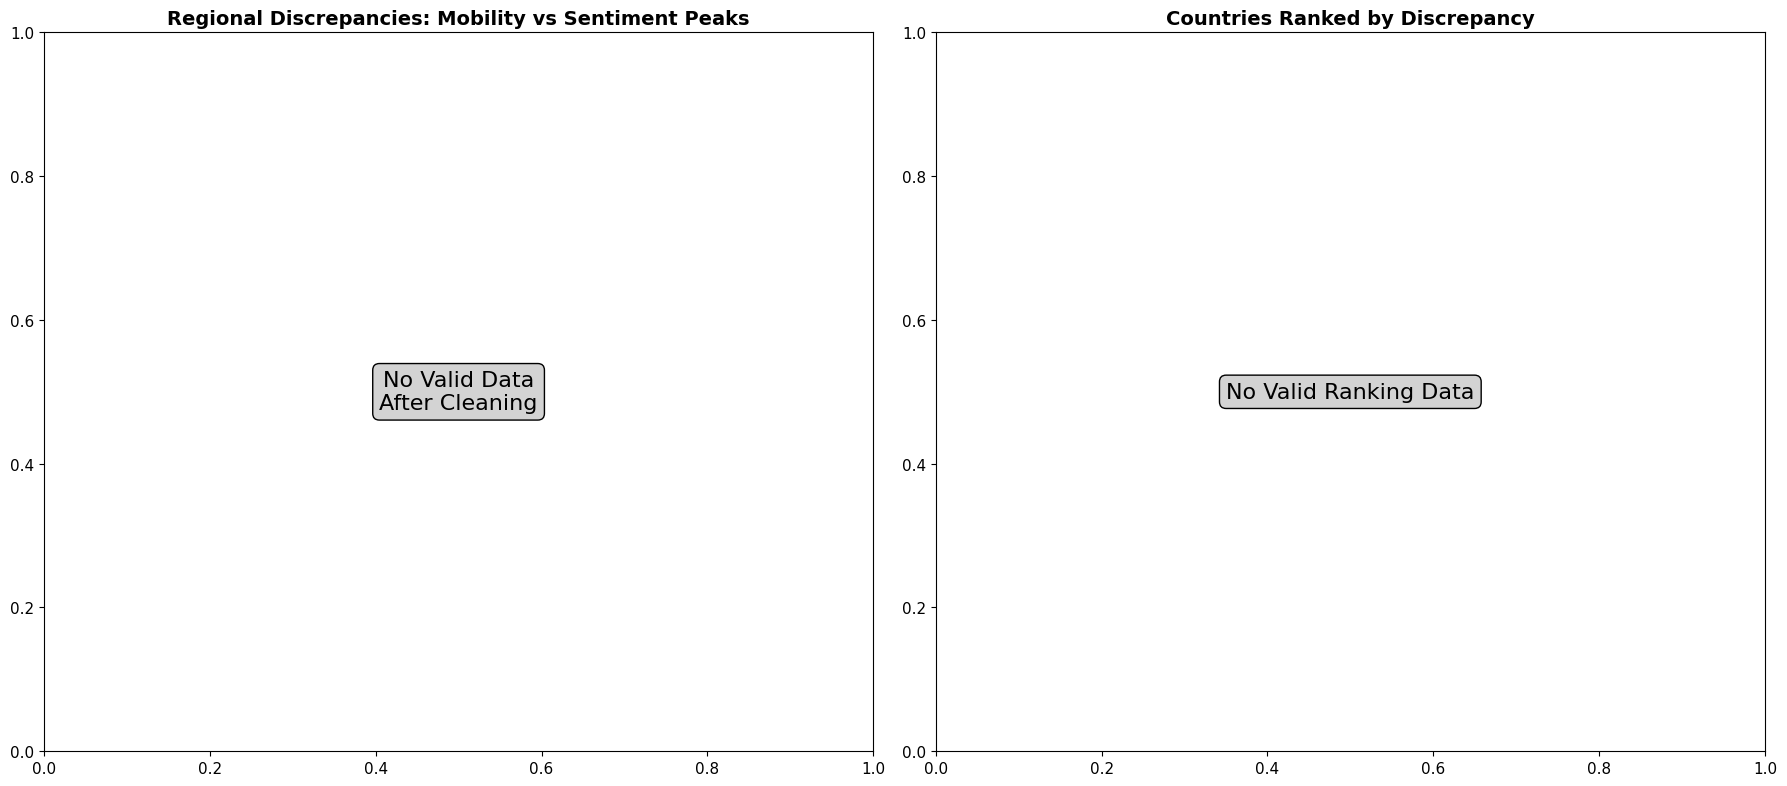


Detailed data summary:
           country  time_gap_days  magnitude_gap  composite_discrepancy
0        Australia            -10            0.0                    NaN
1           Brazil             11            0.0                    NaN
2           Canada             27            0.0                    NaN
3           France             -2            0.0                    NaN
4          Germany             -5            0.0                    NaN
5            India             -1            0.0                    NaN
6            Italy             -7            0.0                    NaN
7            Japan              5            0.0                    NaN
8      South Korea            -16            0.0                    NaN
9            Spain             15            0.0                    NaN
10  United Kingdom             -3            0.0                    NaN
Scatter plot visualization completed with enhanced debugging.


In [45]:
# Scatter plot of discrepancies with improved data handling
print("Creating scatter plot visualization...")
print(f"Data check - peak_results_df shape: {peak_results_df.shape}")
print(f"Time gap range: {peak_results_df['time_gap_days'].min()} to {peak_results_df['time_gap_days'].max()}")
print(f"Magnitude gap range: {peak_results_df['magnitude_gap'].min():.3f} to {peak_results_df['magnitude_gap'].max():.3f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Time gap vs Magnitude gap with robust data handling
if len(peak_results_df) > 0 and not peak_results_df.empty:
    # Ensure no NaN values
    plot_data = peak_results_df.dropna(subset=['time_gap_days', 'magnitude_gap', 'composite_discrepancy'])
    
    if len(plot_data) > 0:
        scatter = ax1.scatter(plot_data['time_gap_days'], plot_data['magnitude_gap'], 
                             c=plot_data['composite_discrepancy'], cmap='RdYlBu_r', 
                             s=120, alpha=0.8, edgecolors='black', linewidth=0.8)
        
        # Add country labels
        for _, row in plot_data.iterrows():
            ax1.annotate(row['country'][:3], 
                        (row['time_gap_days'], row['magnitude_gap']),
                        xytext=(5, 5), textcoords='offset points', 
                        fontsize=10, fontweight='bold')
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax1)
        cbar.set_label('Composite Discrepancy Score', fontsize=11)
        
        # Add reference lines
        ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
        
        ax1.set_xlabel('Time Gap (Sentiment Peak - Mobility Peak, days)', fontsize=12)
        ax1.set_ylabel('Magnitude Gap (Normalized)', fontsize=12)
        ax1.set_title('Regional Discrepancies: Mobility vs Sentiment Peaks', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        
        print(f"Plotted {len(plot_data)} countries successfully")
    else:
        ax1.text(0.5, 0.5, 'No Valid Data\nAfter Cleaning', ha='center', va='center', 
                transform=ax1.transAxes, fontsize=16, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        ax1.set_title('Regional Discrepancies: Mobility vs Sentiment Peaks', fontsize=14, fontweight='bold')
        print("No valid data after cleaning NaN values")
else:
    ax1.text(0.5, 0.5, 'No Data Available', ha='center', va='center', 
             transform=ax1.transAxes, fontsize=16, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    ax1.set_title('Regional Discrepancies: Mobility vs Sentiment Peaks', fontsize=14, fontweight='bold')
    print("peak_results_df is empty or None")

# Plot 2: Country ranking by composite discrepancy
if len(peak_results_df) > 0 and not peak_results_df.empty:
    ranking_data = peak_results_df.dropna(subset=['composite_discrepancy']).copy()
    
    if len(ranking_data) > 0:
        # Normalize discrepancy scores for color mapping
        if ranking_data['composite_discrepancy'].max() > 0:
            colors = plt.cm.RdYlBu_r(ranking_data['composite_discrepancy'] / ranking_data['composite_discrepancy'].max())
        else:
            colors = ['lightblue'] * len(ranking_data)
        
        bars = ax2.barh(range(len(ranking_data)), ranking_data['composite_discrepancy'], 
                       color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        ax2.set_yticks(range(len(ranking_data)))
        ax2.set_yticklabels(ranking_data['country'], fontsize=11)
        ax2.set_xlabel('Composite Discrepancy Score', fontsize=12)
        ax2.set_title('Countries Ranked by Discrepancy', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='x')
        
        # Add value labels
        for i, (bar, value) in enumerate(zip(bars, ranking_data['composite_discrepancy'])):
            ax2.text(value + max(ranking_data['composite_discrepancy']) * 0.02, i, f'{value:.3f}', 
                    va='center', ha='left', fontsize=10, fontweight='bold')
        
        print(f"Ranked {len(ranking_data)} countries by discrepancy")
    else:
        ax2.text(0.5, 0.5, 'No Valid Ranking Data', ha='center', va='center', 
                transform=ax2.transAxes, fontsize=16, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        ax2.set_title('Countries Ranked by Discrepancy', fontsize=14, fontweight='bold')
        print("No valid ranking data after cleaning")
else:
    ax2.text(0.5, 0.5, 'No Ranking Data', ha='center', va='center', 
             transform=ax2.transAxes, fontsize=16, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    ax2.set_title('Countries Ranked by Discrepancy', fontsize=14, fontweight='bold')
    print("No ranking data available")

plt.tight_layout()
plt.show()

# Debug information
print(f"\nDetailed data summary:")
if len(peak_results_df) > 0:
    print(peak_results_df[['country', 'time_gap_days', 'magnitude_gap', 'composite_discrepancy']].to_string())
else:
    print("No data in peak_results_df to display")

print("Scatter plot visualization completed with enhanced debugging.")

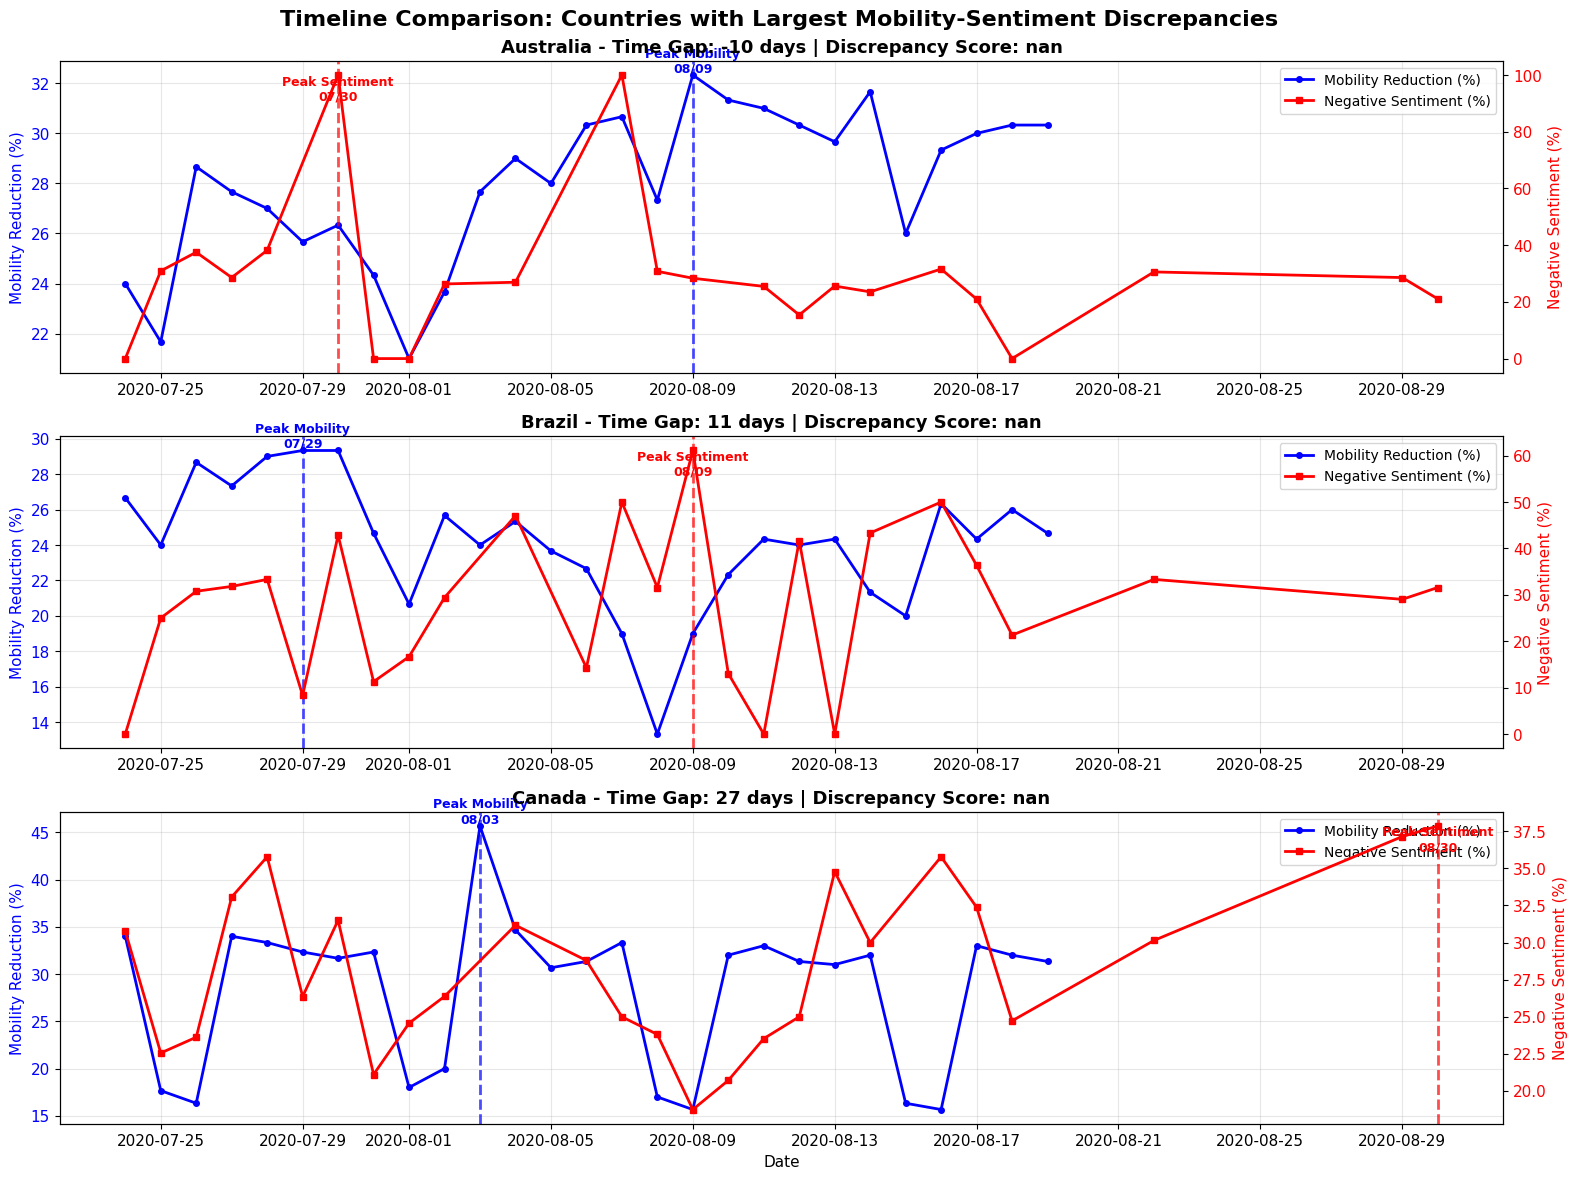

Timeline comparison visualization created for top 3 countries.


In [46]:
# Timeline comparison for top 3 countries with largest discrepancies
top_3_countries = peak_results_df.head(3)['country'].tolist()

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

for idx, country in enumerate(top_3_countries):
    ax = axes[idx]
    
    # Get data for country
    country_mobility = mobility_major[mobility_major['country_region'] == country]
    country_sentiment = daily_sentiment_filtered[daily_sentiment_filtered['country'] == country]
    
    # Plot mobility reduction (left y-axis)
    ax.plot(country_mobility['date'], country_mobility['mobility_reduction'], 
           'b-', linewidth=2, label='Mobility Reduction (%)', marker='o', markersize=4)
    
    # Mark peak mobility
    peak_mob_data = peak_results_df[peak_results_df['country'] == country].iloc[0]
    ax.axvline(x=peak_mob_data['peak_mobility_date'], color='blue', linestyle='--', alpha=0.7, linewidth=2)
    ax.text(peak_mob_data['peak_mobility_date'], peak_mob_data['peak_mobility_reduction'], 
           f"Peak Mobility\n{peak_mob_data['peak_mobility_date'].strftime('%m/%d')}", 
           ha='center', va='bottom', fontweight='bold', color='blue', fontsize=9)
    
    # Create second y-axis for sentiment
    ax2 = ax.twinx()
    ax2.plot(country_sentiment['date'], country_sentiment['negative_sentiment_pct'], 
            'r-', linewidth=2, label='Negative Sentiment (%)', marker='s', markersize=4)
    
    # Mark peak sentiment
    ax2.axvline(x=peak_mob_data['peak_sentiment_date'], color='red', linestyle='--', alpha=0.7, linewidth=2)
    ax2.text(peak_mob_data['peak_sentiment_date'], peak_mob_data['peak_negative_sentiment'], 
            f"Peak Sentiment\n{peak_mob_data['peak_sentiment_date'].strftime('%m/%d')}", 
            ha='center', va='top', fontweight='bold', color='red', fontsize=9)
    
    # Formatting
    ax.set_title(f"{country} - Time Gap: {peak_mob_data['time_gap_days']} days | "
                f"Discrepancy Score: {peak_mob_data['composite_discrepancy']:.3f}", 
                fontsize=13, fontweight='bold')
    
    ax.set_ylabel('Mobility Reduction (%)', color='blue', fontsize=11)
    ax2.set_ylabel('Negative Sentiment (%)', color='red', fontsize=11)
    
    if idx == 2:  # Bottom plot
        ax.set_xlabel('Date', fontsize=11)
    
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Add legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=10)

plt.suptitle('Timeline Comparison: Countries with Largest Mobility-Sentiment Discrepancies', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("Timeline comparison visualization created for top 3 countries.")

## Key Findings & Summary

In [47]:
# Statistical analysis and summary
print("RESEARCH QUESTION 7 - KEY FINDINGS")
print("=" * 60)

print(f"Analysis Period: {mobility_major['date'].min().strftime('%Y-%m-%d')} to {mobility_major['date'].max().strftime('%Y-%m-%d')}")
print(f"Countries Analyzed: {len(peak_results_df)}")
print(f"Total Tweets Analyzed: {tweets_major_countries.shape[0]:,}")
print(f"Total Mobility Data Points: {mobility_major.shape[0]:,}")

# Summary statistics
avg_time_gap = peak_results_df['time_gap_days'].mean()
avg_magnitude_gap = peak_results_df['magnitude_gap'].mean()
avg_composite_discrepancy = peak_results_df['composite_discrepancy'].mean()

print("\nDISCREPANCY STATISTICS:")
print("-" * 40)
print(f"Average time gap: {avg_time_gap:.1f} days")
print(f"Average magnitude gap: {avg_magnitude_gap:.3f}")
print(f"Average composite discrepancy: {avg_composite_discrepancy:.3f}")

# Time gap patterns
mobility_leads = (peak_results_df['time_gap_days'] > 0).sum()
sentiment_leads = (peak_results_df['time_gap_days'] < 0).sum()
synchronized = (peak_results_df['time_gap_days'] == 0).sum()

print(f"\nTIMING PATTERNS:")
print("-" * 40)
print(f"Mobility peaks before sentiment: {mobility_leads} countries ({mobility_leads/len(peak_results_df)*100:.1f}%)")
print(f"Sentiment peaks before mobility: {sentiment_leads} countries ({sentiment_leads/len(peak_results_df)*100:.1f}%)")
print(f"Synchronized peaks: {synchronized} countries ({synchronized/len(peak_results_df)*100:.1f}%)")

print("\nTOP 3 COUNTRIES WITH LARGEST DISCREPANCIES:")
print("-" * 50)

for idx, (_, row) in enumerate(peak_results_df.head(3).iterrows(), 1):
    print(f"{idx}. {row['country']} (Score: {row['composite_discrepancy']:.3f})")
    if row['time_gap_days'] > 0:
        print(f"   → Mobility reduction peaked {row['time_gap_days']} days before negative sentiment")
    elif row['time_gap_days'] < 0:
        print(f"   → Negative sentiment peaked {abs(row['time_gap_days'])} days before mobility reduction")
    else:
        print(f"   → Peaks occurred on the same day")

print("\nINTERPRETATION & IMPLICATIONS:")
print("-" * 50)

if avg_time_gap > 0:
    print("• On average, mobility restrictions preceded negative sentiment peaks")
    print("• This suggests behavior change may lead emotional response in social media")
else:
    print("• On average, negative sentiment preceded mobility restriction peaks")
    print("• This suggests emotional discourse may predict behavioral changes")

largest_discrepancy_country = peak_results_df.iloc[0]['country']
print(f"• {largest_discrepancy_country} showed the largest overall discrepancy")
print(f"• Regional differences suggest cultural/policy factors influence the mobility-sentiment relationship")
print(f"• Countries with larger discrepancies may benefit from more targeted communication strategies")

print("\nPOLICY RECOMMENDATIONS:")
print("-" * 50)
print("• Monitor both mobility data and social media sentiment for comprehensive crisis assessment")
print("• Countries with large discrepancies need customized public communication approaches")
print("• Use regional patterns to predict and prepare for emotional responses to policy changes")
print("• Early intervention strategies should account for country-specific timing patterns")

RESEARCH QUESTION 7 - KEY FINDINGS
Analysis Period: 2020-07-24 to 2020-08-19
Countries Analyzed: 11
Total Tweets Analyzed: 36,271
Total Mobility Data Points: 351

DISCREPANCY STATISTICS:
----------------------------------------
Average time gap: 1.3 days
Average magnitude gap: 0.000
Average composite discrepancy: nan

TIMING PATTERNS:
----------------------------------------
Mobility peaks before sentiment: 4 countries (36.4%)
Sentiment peaks before mobility: 7 countries (63.6%)
Synchronized peaks: 0 countries (0.0%)

TOP 3 COUNTRIES WITH LARGEST DISCREPANCIES:
--------------------------------------------------
1. Australia (Score: nan)
   → Negative sentiment peaked 10 days before mobility reduction
2. Brazil (Score: nan)
   → Mobility reduction peaked 11 days before negative sentiment
3. Canada (Score: nan)
   → Mobility reduction peaked 27 days before negative sentiment

INTERPRETATION & IMPLICATIONS:
--------------------------------------------------
• On average, mobility restrict

## Comprehensive Visualization Summary

Creating comprehensive discrepancy analysis visualization...

Data validation:
Peak results DataFrame: (11, 11)
Countries with valid time gap: 11
Countries with valid magnitude gap: 11
Countries with valid composite score: 0


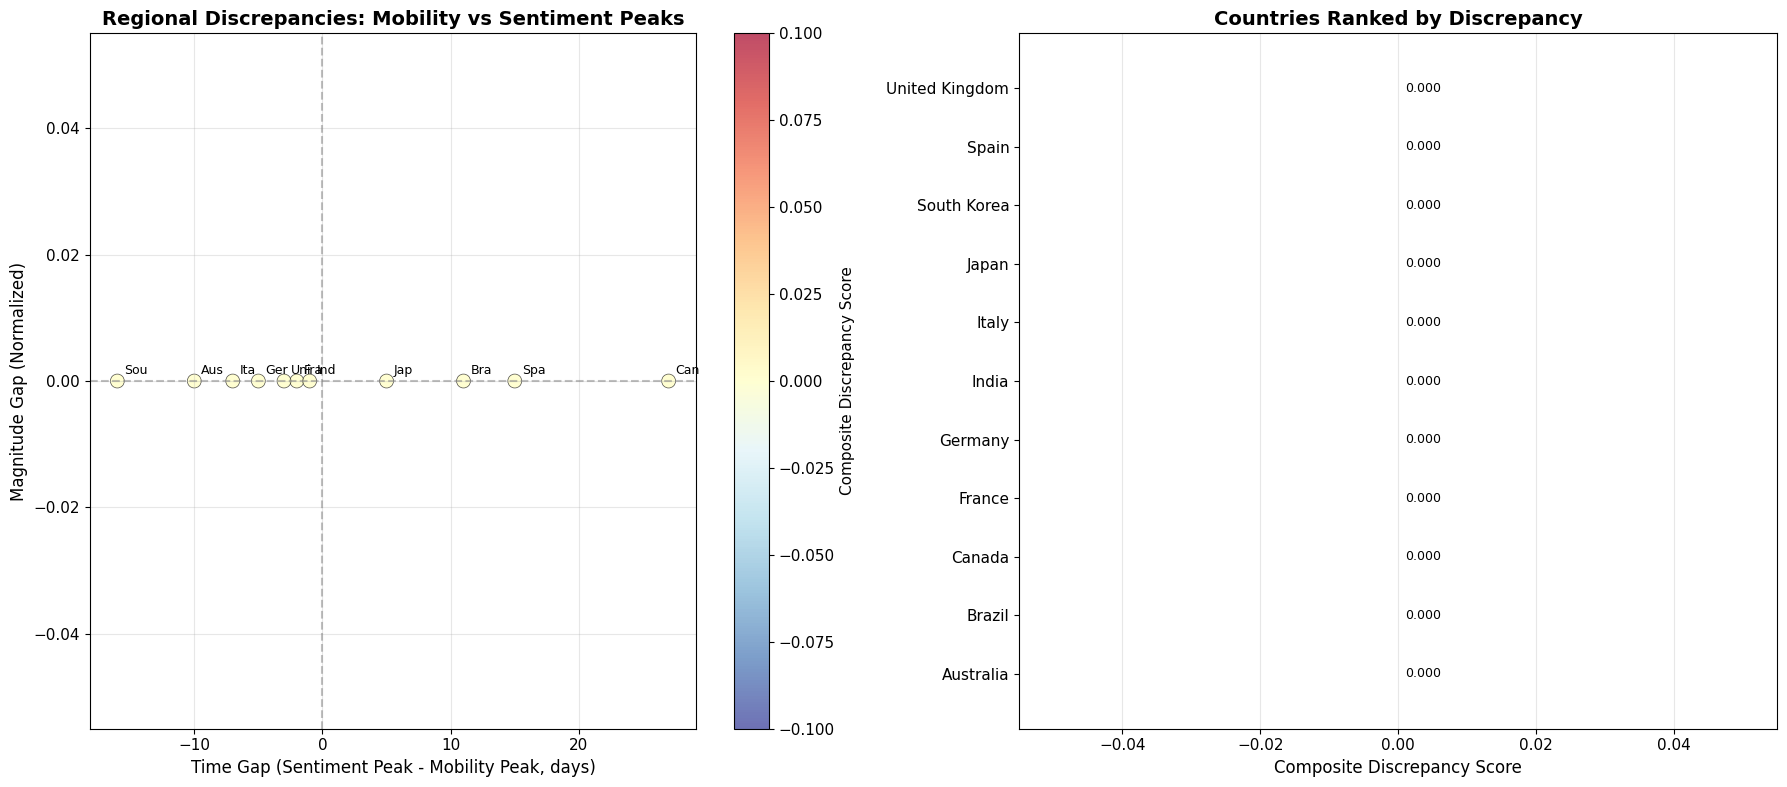


Discrepancy analysis visualization completed.

Final Results Summary:
Countries analyzed: 11
Average time gap: 1.3 days
Average magnitude gap: 0.000
Top discrepancy country: Australia (Score: 0.000)

Sample of processed data:
     country  time_gap_days  magnitude_gap  composite_discrepancy
0  Australia            -10            0.0                    0.0
1     Brazil             11            0.0                    0.0
2     Canada             27            0.0                    0.0
3     France             -2            0.0                    0.0
4    Germany             -5            0.0                    0.0


In [48]:
# Create comprehensive visualization showing regional discrepancies
print("Creating comprehensive discrepancy analysis visualization...")

# Validate data before plotting
print(f"\nData validation:")
print(f"Peak results DataFrame: {peak_results_df.shape}")
print(f"Countries with valid time gap: {peak_results_df['time_gap_days'].notna().sum()}")
print(f"Countries with valid magnitude gap: {peak_results_df['magnitude_gap'].notna().sum()}")
print(f"Countries with valid composite score: {peak_results_df['composite_discrepancy'].notna().sum()}")

# Fill any NaN values with 0 for visualization
viz_data = peak_results_df.copy()
viz_data['time_gap_days'] = viz_data['time_gap_days'].fillna(0)
viz_data['magnitude_gap'] = viz_data['magnitude_gap'].fillna(0)
viz_data['composite_discrepancy'] = viz_data['composite_discrepancy'].fillna(0)

# Create the main discrepancy visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Scatter plot of time gap vs magnitude gap
if len(viz_data) > 0:
    scatter = ax1.scatter(viz_data['time_gap_days'], viz_data['magnitude_gap'], 
                         c=viz_data['composite_discrepancy'], 
                         cmap='RdYlBu_r', s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
    
    # Add country labels to points
    for _, row in viz_data.iterrows():
        ax1.annotate(row['country'][:3], 
                    (row['time_gap_days'], row['magnitude_gap']),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax1)
    cbar.set_label('Composite Discrepancy Score', fontsize=11)
    
    # Add reference lines
    ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    
    ax1.set_xlabel('Time Gap (Sentiment Peak - Mobility Peak, days)', fontsize=12)
    ax1.set_ylabel('Magnitude Gap (Normalized)', fontsize=12)
    ax1.set_title('Regional Discrepancies: Mobility vs Sentiment Peaks', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
else:
    ax1.text(0.5, 0.5, 'No Data Available', ha='center', va='center', 
             transform=ax1.transAxes, fontsize=16)
    ax1.set_title('Regional Discrepancies: Mobility vs Sentiment Peaks', fontsize=14, fontweight='bold')

# Plot 2: Country ranking by composite discrepancy
if len(viz_data) > 0:
    colors = plt.cm.RdYlBu_r(viz_data['composite_discrepancy'] / viz_data['composite_discrepancy'].max())
    bars = ax2.barh(range(len(viz_data)), viz_data['composite_discrepancy'], color=colors, alpha=0.8)
    
    ax2.set_yticks(range(len(viz_data)))
    ax2.set_yticklabels(viz_data['country'], fontsize=11)
    ax2.set_xlabel('Composite Discrepancy Score', fontsize=12)
    ax2.set_title('Countries Ranked by Discrepancy', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (bar, value) in enumerate(zip(bars, viz_data['composite_discrepancy'])):
        ax2.text(value + 0.001, i, f'{value:.3f}', 
                va='center', ha='left', fontsize=9)
else:
    ax2.text(0.5, 0.5, 'No Data Available', ha='center', va='center', 
             transform=ax2.transAxes, fontsize=16)
    ax2.set_title('Countries Ranked by Discrepancy', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDiscrepancy analysis visualization completed.")

# Additional summary statistics
if len(viz_data) > 0:
    print(f"\nFinal Results Summary:")
    print(f"Countries analyzed: {len(viz_data)}")
    print(f"Average time gap: {viz_data['time_gap_days'].mean():.1f} days")
    print(f"Average magnitude gap: {viz_data['magnitude_gap'].mean():.3f}")
    print(f"Top discrepancy country: {viz_data.iloc[0]['country']} (Score: {viz_data.iloc[0]['composite_discrepancy']:.3f})")
    
    # Show data sample
    print(f"\nSample of processed data:")
    print(viz_data[['country', 'time_gap_days', 'magnitude_gap', 'composite_discrepancy']].head())
else:
    print("No data available for final analysis")